# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/OneDrive/ITA/Mestrado/2021_TE-282 - Meta heurísticas/Lab/data/log


In [163]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [164]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [165]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [166]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [167]:
all_dfs = []
best_dfs = []
LOGs = str(LOG_PATH) + '/*.csv'

for file in glob.glob(str(LOGs)):
    df = pd.read_csv(file)
    filename = file[file.find('/log/')+5:]
    df['filename'] = filename
    all_dfs.append(df)
    best_dfs.append(df.iloc[-1:])

all_data = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
all_data.rename({'move_strategy':'move_str',
                 'selection_strategy':'selec_str'}, axis=1, inplace=True)

best_data = pd.concat(best_dfs, ignore_index=True).reset_index(drop=True)
best_data.rename({'move_strategy':'move_str',
                  'selection_strategy':'selec_str'}, axis=1, inplace=True)

In [168]:
# sns.set(style="ticks", context="notebook")
# plt.style.use("dark_background")

In [169]:
print(all_data.shape)
all_data.drop(['Z', 'X'],axis=1).head()

(9200, 22)


,iter,move,improve,obj,return,n_assets,qN,qNv,iter_time,max_iter,neighbours,alpha,exp_return,n_port,k_min,k_max,move_str,seed,selec_str,filename
0,0,idID,True,0.130495,0.002748,10,100,33,0.025611,100,100,0.01,0.001,1,10,10,best,10,best,log_local_search_20211031_190800.csv
1,1,idID,True,0.089638,0.002618,10,100,41,0.025852,100,100,0.01,0.001,1,10,10,best,10,best,log_local_search_20211031_190800.csv
2,2,idID,True,0.080438,0.002703,10,100,28,0.024899,100,100,0.01,0.001,1,10,10,best,10,best,log_local_search_20211031_190800.csv
3,3,idID,True,0.071182,0.002697,10,100,24,0.024665,100,100,0.01,0.001,1,10,10,best,10,best,log_local_search_20211031_190800.csv
4,4,idID,True,0.061672,0.002718,10,100,33,0.026050,100,100,0.01,0.001,1,10,10,best,10,best,log_local_search_20211031_190800.csv


In [170]:
all_data = all_data[all_data.filename.str.contains('20211031')]
print(all_data.shape)

(9200, 22)


In [171]:
all_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
iter,9200.0,NaN,NaN,NaN,49.5,28.867639,0.0,24.75,49.5,74.25,99.0
move,9200,3,TID,6585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
improve,9200,2,False,6426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
obj,9200.0,NaN,NaN,NaN,0.143452,0.09766,0.019159,0.025651,0.190141,0.224553,0.263899
return,9200.0,NaN,NaN,NaN,0.004132,0.002635,0.001,0.002386,0.003149,0.004105,0.010153
n_assets,9200.0,NaN,NaN,NaN,10.0,0.0,10.0,10.0,10.0,10.0,10.0
X,9200,1691,[0.20085997 0.01051067 0.0061462 0.17269486 0...,704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z,9200,304,[ 4 8 10 15 16 21 25 27 28 30],1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qN,9200.0,NaN,NaN,NaN,100.0,0.0,100.0,100.0,100.0,100.0,100.0
qNv,9200.0,NaN,NaN,NaN,21.977935,26.684401,0.0,0.0,0.0,51.0,77.0


## Portfólios

### Estatísticas Básicas

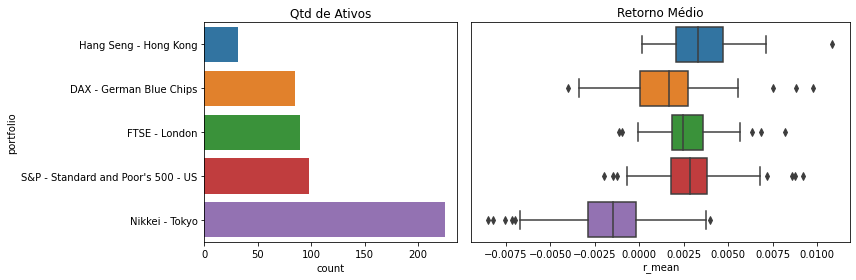

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

In [173]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


### Matriz de Covariância

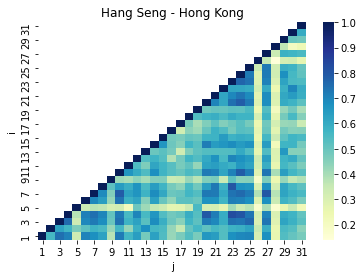

In [174]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

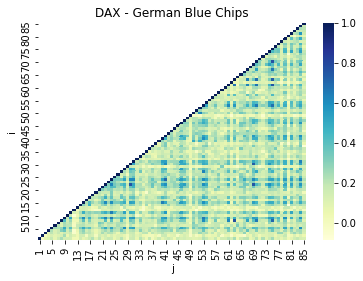

In [175]:
portfolio = 2
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

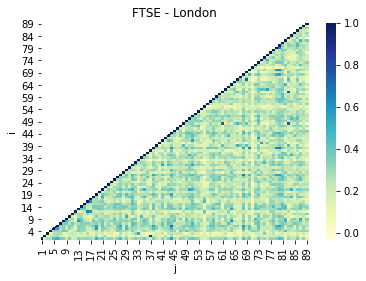

In [176]:
portfolio = 3
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

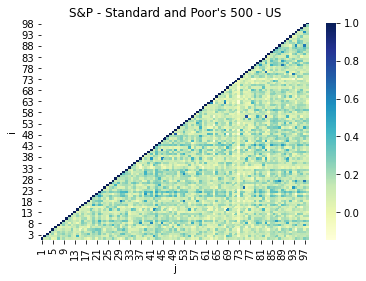

In [177]:
portfolio = 4
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

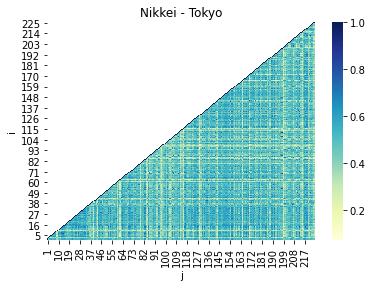

In [178]:
portfolio = 5
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [179]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


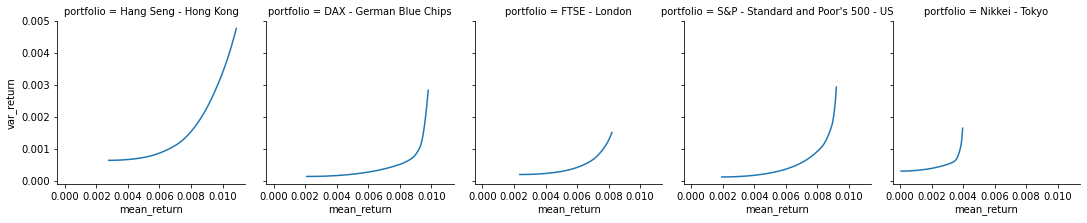

In [180]:
sns.relplot(data=uef, y='var_return', x='mean_return', col='portfolio', kind='line', height=3)

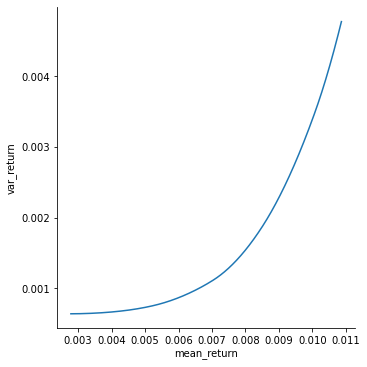

In [181]:
sns.relplot(data=uef[uef.port==1], y='var_return', x='mean_return', kind='line')

## Curvas de Aprendizado

### Avaliação do Impacto da Seed

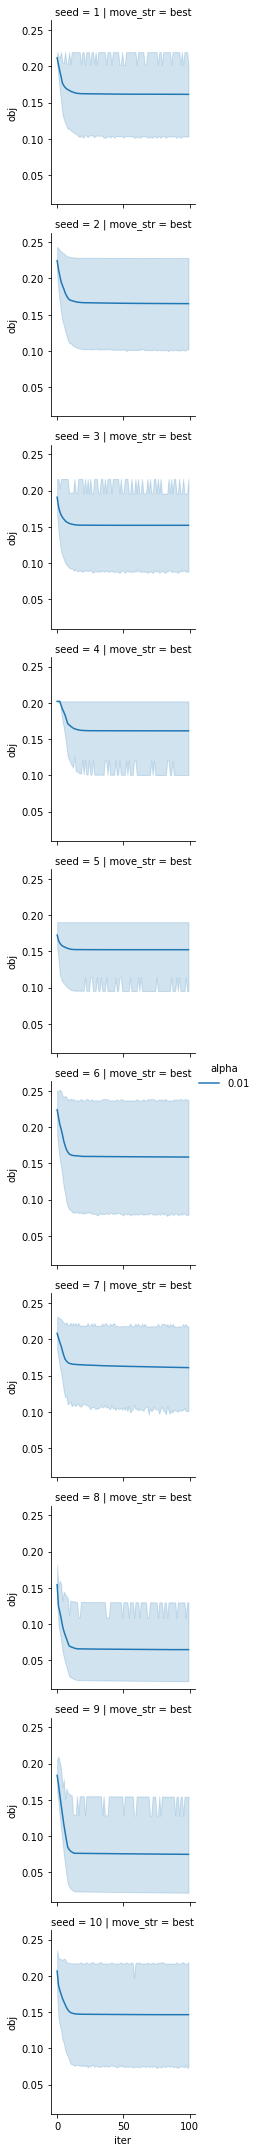

In [182]:
g = sns.FacetGrid(
    data=all_data, row='seed', col='move_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

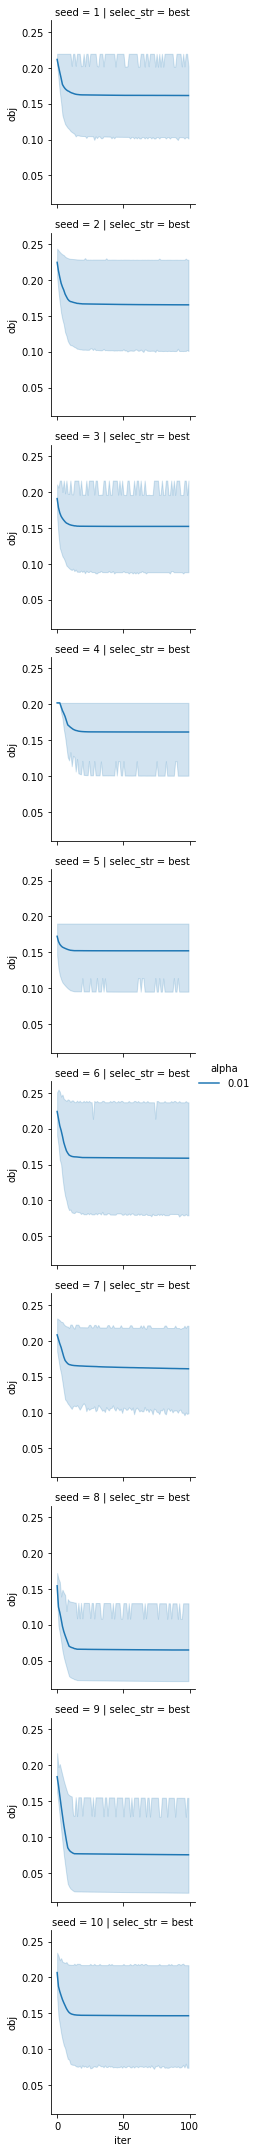

In [183]:
g = sns.FacetGrid(
    data=all_data, row='seed', col='selec_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

### Avaliação do Tipo de Move

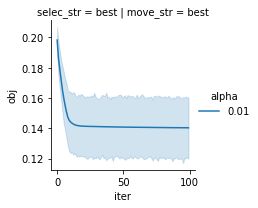

In [184]:
g = sns.FacetGrid(
    data=all_data, row='selec_str', col='move_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

### Avaliação do Impacto do Retorno Experado

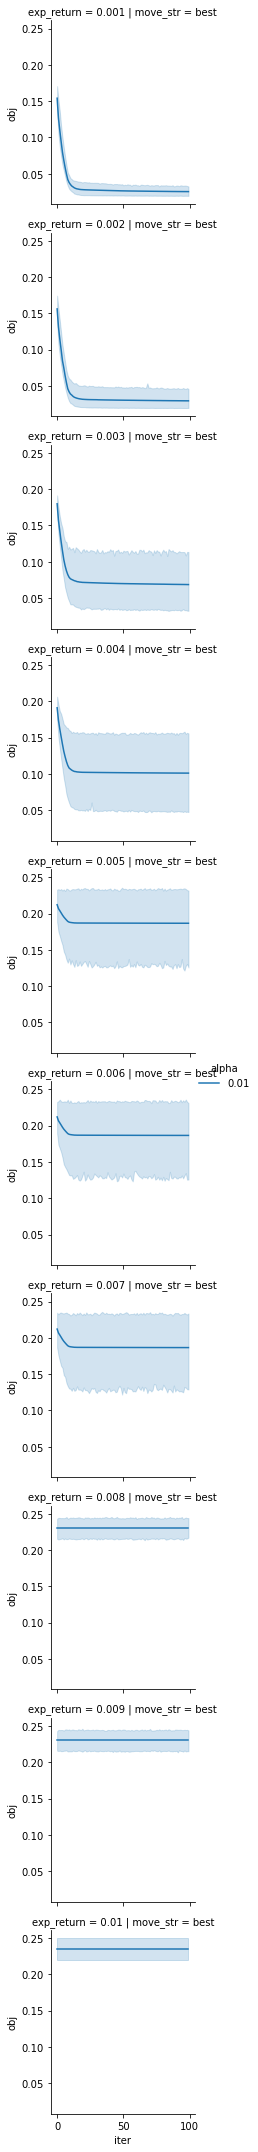

In [185]:
g = sns.FacetGrid(
    data=all_data, row='exp_return', col='move_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

## Análise Best

In [186]:
best_best_data = best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj'].min()

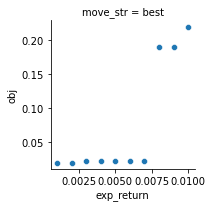

In [187]:
g = sns.FacetGrid(
    data=best_best_data, col='move_str')
g.map(sns.scatterplot, 'exp_return', 'obj')

In [189]:
best_best_data

,exp_return,move_str,selec_str,obj
0,0.001,best,best,0.019159
1,0.002,best,best,0.019159
2,0.003,best,best,0.021310
3,0.004,best,best,0.021310
4,0.005,best,best,0.021310
5,0.006,best,best,0.021310
6,0.007,best,best,0.021310
7,0.008,best,best,0.190141
8,0.009,best,best,0.190141
9,0.010,best,best,0.219578


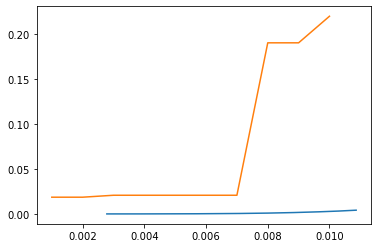

In [192]:
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.plot(best_best_data.exp_return, best_best_data.obj)